## Score imputation strats

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# To use the experimental IterativeImputer, we need to explicitly ask for it:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.pipeline import make_pipeline, make_union
from sklearn.impute import (
    SimpleImputer, KNNImputer, IterativeImputer, MissingIndicator)
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestRegressor

rng = np.random.RandomState(0)

N_SPLITS = 5
# REGRESSOR = RandomForestClassifier(random_state=0)
REGRESSOR = MLPClassifier(alpha = .0001,
                         activation = 'relu',
                         early_stopping = True,
                         hidden_layer_sizes = (150, 150, 150),
                         max_iter = 500,
                         verbose = False)

In [6]:
# pd.read_csv?

In [ ]:
data = pd.read_csv('../src_r/risk_gpa25/data/data_any-adverse-qtrly-outcome.csv', nrows = 1e4)
# data = pd.read_csv('/home/zane/data/freefall/data_any-adverse-qtrly-outcome.csv')
if 'Unnamed: 0' in data.columns:
    data.drop(columns = 'Unnamed: 0', inplace = True)

def recode_cats(df, var_list):
    for x in var_list:
        df = pd.concat([df, pd.get_dummies(df[x],
                                           prefix = x,
                                           dummy_na = False,
                                           drop_first = True)],  # check this opt depending on model(s)
                      axis = 1).drop([x], axis = 1)
    return(df)
    
data = recode_cats(data, ['s1_gender', 'last_school_type', 'scholarship_type', 'major_abbr'])
id_vars = ['system_key', 'yrq']
target = 'Y'
x_vars = [x for x in data.columns if x not in [target]]
x_vars = [x for x in x_vars if x not in id_vars]

In [9]:
X_missing, y_missing = data[x_vars], data[target]

In [26]:
def get_scores_for_imputer(imputer, X_missing, y_missing):
    estimator = make_pipeline(
        make_union(imputer, MissingIndicator(missing_values=np.nan)),
        REGRESSOR)
    impute_scores = cross_val_score(estimator, X_missing, y_missing,
                                    scoring='neg_mean_squared_error',
                                    cv=N_SPLITS)
    return impute_scores

# Test
# def get_results(X_missing, y_missing):
    
#     imputer = SimpleImputer(strategy='constant', fill_value = -99)
#     zero_impute_scores = get_scores_for_imputer(imputer, X_missing, y_missing)
    
#     return((zero_impute_scores.mean(), zero_impute_scores.std()))

def get_results(X_missing, y_missing):

    # Estimate the score after replacing missing values by 0
    imputer = SimpleImputer(strategy='constant',
                            fill_value=-99)
    zero_impute_scores = get_scores_for_imputer(imputer, X_missing, y_missing)

    # Estimate the score after imputation (mean strategy) of the missing values
    imputer = SimpleImputer(strategy="mean")
    mean_impute_scores = get_scores_for_imputer(imputer, X_missing, y_missing)

    # Estimate the score after kNN-imputation of the missing values
    imputer = KNNImputer()
    knn_impute_scores = get_scores_for_imputer(imputer, X_missing, y_missing)

    # Estimate the score after iterative imputation of the missing values
    # 1 round
    imputer = IterativeImputer(max_iter = 1,
                               skip_complete = True,
                               random_state=0,
                               n_nearest_features=10,
                               sample_posterior=True)
    iterative_impute_1_scores = get_scores_for_imputer(imputer,
                                                     X_missing,
                                                     y_missing)
    
    # Estimate the score after iterative imputation of the missing values
    # 10 rounds
    imputer = IterativeImputer(max_iter = 10,
                               skip_complete = True,
                               random_state=0,
                               n_nearest_features=10,
                               sample_posterior=True)
    iterative_impute_10_scores = get_scores_for_imputer(imputer,
                                                     X_missing,
                                                     y_missing)

    return ((zero_impute_scores.mean(), zero_impute_scores.std()),
            (mean_impute_scores.mean(), mean_impute_scores.std()),
            (knn_impute_scores.mean(), knn_impute_scores.std()),
            (iterative_impute_1_scores.mean(), iterative_impute_1_scores.std()),
            (iterative_impute_10_scores.mean(), iterative_impute_10_scores.std()))

In [27]:
results = get_results(X_missing, y_missing)

Iteration 1, loss = 1.40698390
Validation score: 0.618750
Iteration 2, loss = 0.64570308
Validation score: 0.616250
Iteration 3, loss = 0.62433728
Validation score: 0.627500
Iteration 4, loss = 0.60620856
Validation score: 0.652500
Iteration 5, loss = 0.59147473
Validation score: 0.640000
Iteration 6, loss = 0.56759618
Validation score: 0.632500
Iteration 7, loss = 0.57501178
Validation score: 0.685000
Iteration 8, loss = 0.54739317
Validation score: 0.637500
Iteration 9, loss = 0.55024579
Validation score: 0.676250
Iteration 10, loss = 0.54789057
Validation score: 0.651250
Iteration 11, loss = 0.56607867
Validation score: 0.676250
Iteration 12, loss = 0.51990029
Validation score: 0.670000
Iteration 13, loss = 0.52531729
Validation score: 0.653750
Iteration 14, loss = 0.53226512
Validation score: 0.650000
Iteration 15, loss = 0.52395238
Validation score: 0.672500
Iteration 16, loss = 0.55141917
Validation score: 0.621250
Iteration 17, loss = 0.51119578
Validation score: 0.670000
Iterat

Iteration 7, loss = 0.60466801
Validation score: 0.653750
Iteration 8, loss = 0.57247853
Validation score: 0.682500
Iteration 9, loss = 0.56178834
Validation score: 0.662500
Iteration 10, loss = 0.57393583
Validation score: 0.690000
Iteration 11, loss = 0.58073676
Validation score: 0.672500
Iteration 12, loss = 0.55656421
Validation score: 0.686250
Iteration 13, loss = 0.54186763
Validation score: 0.700000
Iteration 14, loss = 0.53685511
Validation score: 0.687500
Iteration 15, loss = 0.53218907
Validation score: 0.648750
Iteration 16, loss = 0.53265867
Validation score: 0.690000
Iteration 17, loss = 0.52648719
Validation score: 0.711250
Iteration 18, loss = 0.52319447
Validation score: 0.701250
Iteration 19, loss = 0.50264479
Validation score: 0.708750
Iteration 20, loss = 0.50325066
Validation score: 0.705000
Iteration 21, loss = 0.51525686
Validation score: 0.671250
Iteration 22, loss = 0.50188435
Validation score: 0.685000
Iteration 23, loss = 0.49798421
Validation score: 0.692500


Iteration 9, loss = 0.47492513
Validation score: 0.720000
Iteration 10, loss = 0.46098510
Validation score: 0.730000
Iteration 11, loss = 0.44359133
Validation score: 0.723750
Iteration 12, loss = 0.43190114
Validation score: 0.685000
Iteration 13, loss = 0.43722265
Validation score: 0.736250
Iteration 14, loss = 0.43047837
Validation score: 0.730000
Iteration 15, loss = 0.39927966
Validation score: 0.731250
Iteration 16, loss = 0.39950460
Validation score: 0.745000
Iteration 17, loss = 0.37982056
Validation score: 0.721250
Iteration 18, loss = 0.37770576
Validation score: 0.720000
Iteration 19, loss = 0.35847986
Validation score: 0.711250
Iteration 20, loss = 0.35964067
Validation score: 0.716250
Iteration 21, loss = 0.33162200
Validation score: 0.722500
Iteration 22, loss = 0.32696872
Validation score: 0.707500
Iteration 23, loss = 0.31899175
Validation score: 0.728750
Iteration 24, loss = 0.32439638
Validation score: 0.726250
Iteration 25, loss = 0.31774317
Validation score: 0.72500

Iteration 20, loss = 0.38510021
Validation score: 0.716250
Iteration 21, loss = 0.37757812
Validation score: 0.722500
Iteration 22, loss = 0.36913926
Validation score: 0.736250
Iteration 23, loss = 0.36501577
Validation score: 0.735000
Iteration 24, loss = 0.33602452
Validation score: 0.747500
Iteration 25, loss = 0.31709174
Validation score: 0.711250
Iteration 26, loss = 0.31721679
Validation score: 0.736250
Iteration 27, loss = 0.32408455
Validation score: 0.728750
Iteration 28, loss = 0.29297576
Validation score: 0.737500
Iteration 29, loss = 0.29478114
Validation score: 0.730000
Iteration 30, loss = 0.27845545
Validation score: 0.715000
Iteration 31, loss = 0.32953486
Validation score: 0.711250
Iteration 32, loss = 0.27600843
Validation score: 0.713750
Iteration 33, loss = 0.26452558
Validation score: 0.718750
Iteration 34, loss = 0.24084290
Validation score: 0.731250
Iteration 35, loss = 0.22821545
Validation score: 0.742500
Validation score did not improve more than tol=0.000100 

/Users/zane/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: divide by zero encountered in true_divide
  c /= stddev[:, None]
/Users/zane/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: divide by zero encountered in true_divide
  c /= stddev[None, :]


Iteration 1, loss = 0.70515764
Validation score: 0.697500
Iteration 2, loss = 0.56365470
Validation score: 0.732500
Iteration 3, loss = 0.54086572
Validation score: 0.692500
Iteration 4, loss = 0.53203235
Validation score: 0.733750
Iteration 5, loss = 0.50662800
Validation score: 0.730000
Iteration 6, loss = 0.49577445
Validation score: 0.738750
Iteration 7, loss = 0.48791782
Validation score: 0.730000
Iteration 8, loss = 0.47683030
Validation score: 0.738750
Iteration 9, loss = 0.45922032
Validation score: 0.723750
Iteration 10, loss = 0.45052755
Validation score: 0.763750
Iteration 11, loss = 0.44879964
Validation score: 0.738750
Iteration 12, loss = 0.43453140
Validation score: 0.717500
Iteration 13, loss = 0.41866717
Validation score: 0.743750
Iteration 14, loss = 0.41561477
Validation score: 0.736250
Iteration 15, loss = 0.39723087
Validation score: 0.720000
Iteration 16, loss = 0.39853195
Validation score: 0.737500
Iteration 17, loss = 0.37294639
Validation score: 0.722500
Iterat

/Users/zane/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: divide by zero encountered in true_divide
  c /= stddev[:, None]
/Users/zane/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: divide by zero encountered in true_divide
  c /= stddev[None, :]


Iteration 1, loss = 0.70772567
Validation score: 0.672500
Iteration 2, loss = 0.57478372
Validation score: 0.690000
Iteration 3, loss = 0.54640337
Validation score: 0.728750
Iteration 4, loss = 0.53600678
Validation score: 0.746250
Iteration 5, loss = 0.51604068
Validation score: 0.738750
Iteration 6, loss = 0.50936576
Validation score: 0.722500
Iteration 7, loss = 0.51219827
Validation score: 0.733750
Iteration 8, loss = 0.49551080
Validation score: 0.751250
Iteration 9, loss = 0.48106876
Validation score: 0.743750
Iteration 10, loss = 0.46764073
Validation score: 0.733750
Iteration 11, loss = 0.46413177
Validation score: 0.731250
Iteration 12, loss = 0.45362451
Validation score: 0.733750
Iteration 13, loss = 0.45831796
Validation score: 0.725000
Iteration 14, loss = 0.43043654
Validation score: 0.737500
Iteration 15, loss = 0.42466757
Validation score: 0.730000
Iteration 16, loss = 0.40520902
Validation score: 0.698750
Iteration 17, loss = 0.39760117
Validation score: 0.740000
Iterat

/Users/zane/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: divide by zero encountered in true_divide
  c /= stddev[:, None]
/Users/zane/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: divide by zero encountered in true_divide
  c /= stddev[None, :]


Iteration 1, loss = 0.71222790
Validation score: 0.663750
Iteration 2, loss = 0.58580359
Validation score: 0.732500
Iteration 3, loss = 0.55239136
Validation score: 0.745000
Iteration 4, loss = 0.53501867
Validation score: 0.738750
Iteration 5, loss = 0.52209775
Validation score: 0.748750
Iteration 6, loss = 0.51106754
Validation score: 0.695000
Iteration 7, loss = 0.51494443
Validation score: 0.737500
Iteration 8, loss = 0.49661239
Validation score: 0.741250
Iteration 9, loss = 0.48667564
Validation score: 0.757500
Iteration 10, loss = 0.46885133
Validation score: 0.737500
Iteration 11, loss = 0.46396745
Validation score: 0.733750
Iteration 12, loss = 0.45424872
Validation score: 0.737500
Iteration 13, loss = 0.43966944
Validation score: 0.742500
Iteration 14, loss = 0.43042694
Validation score: 0.732500
Iteration 15, loss = 0.41948782
Validation score: 0.737500
Iteration 16, loss = 0.41947054
Validation score: 0.730000
Iteration 17, loss = 0.40090200
Validation score: 0.711250
Iterat

/Users/zane/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: divide by zero encountered in true_divide
  c /= stddev[:, None]
/Users/zane/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: divide by zero encountered in true_divide
  c /= stddev[None, :]


Iteration 1, loss = 0.68604843
Validation score: 0.696250
Iteration 2, loss = 0.57765371
Validation score: 0.761250
Iteration 3, loss = 0.55532873
Validation score: 0.696250
Iteration 4, loss = 0.53950908
Validation score: 0.727500
Iteration 5, loss = 0.53100523
Validation score: 0.745000
Iteration 6, loss = 0.51508353
Validation score: 0.741250
Iteration 7, loss = 0.50355858
Validation score: 0.745000
Iteration 8, loss = 0.50414872
Validation score: 0.751250
Iteration 9, loss = 0.48106594
Validation score: 0.757500
Iteration 10, loss = 0.46944087
Validation score: 0.741250
Iteration 11, loss = 0.46466998
Validation score: 0.741250
Iteration 12, loss = 0.45978932
Validation score: 0.732500
Iteration 13, loss = 0.44764244
Validation score: 0.748750
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


/Users/zane/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: divide by zero encountered in true_divide
  c /= stddev[:, None]
/Users/zane/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: divide by zero encountered in true_divide
  c /= stddev[None, :]


Iteration 1, loss = 0.65658707
Validation score: 0.686250
Iteration 2, loss = 0.56589409
Validation score: 0.692500
Iteration 3, loss = 0.54383042
Validation score: 0.703750
Iteration 4, loss = 0.53738279
Validation score: 0.705000
Iteration 5, loss = 0.52152068
Validation score: 0.716250
Iteration 6, loss = 0.50753648
Validation score: 0.712500
Iteration 7, loss = 0.50116178
Validation score: 0.691250
Iteration 8, loss = 0.48959048
Validation score: 0.705000
Iteration 9, loss = 0.47780448
Validation score: 0.710000
Iteration 10, loss = 0.46438869
Validation score: 0.706250
Iteration 11, loss = 0.46732423
Validation score: 0.715000
Iteration 12, loss = 0.44433765
Validation score: 0.725000
Iteration 13, loss = 0.43243533
Validation score: 0.717500
Iteration 14, loss = 0.42919933
Validation score: 0.705000
Iteration 15, loss = 0.42372357
Validation score: 0.702500
Iteration 16, loss = 0.42132476
Validation score: 0.705000
Iteration 17, loss = 0.40306084
Validation score: 0.715000
Iterat

/Users/zane/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: divide by zero encountered in true_divide
  c /= stddev[:, None]
/Users/zane/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: divide by zero encountered in true_divide
  c /= stddev[None, :]


Iteration 1, loss = 0.71608495
Validation score: 0.611250
Iteration 2, loss = 0.57316883
Validation score: 0.697500
Iteration 3, loss = 0.54238914
Validation score: 0.728750
Iteration 4, loss = 0.52087204
Validation score: 0.721250
Iteration 5, loss = 0.50905582
Validation score: 0.737500
Iteration 6, loss = 0.49642691
Validation score: 0.723750
Iteration 7, loss = 0.49317141
Validation score: 0.746250
Iteration 8, loss = 0.48500213
Validation score: 0.742500
Iteration 9, loss = 0.46915238
Validation score: 0.761250
Iteration 10, loss = 0.46809151
Validation score: 0.750000
Iteration 11, loss = 0.44748227
Validation score: 0.750000
Iteration 12, loss = 0.45988214
Validation score: 0.708750
Iteration 13, loss = 0.44207670
Validation score: 0.745000
Iteration 14, loss = 0.43152999
Validation score: 0.760000
Iteration 15, loss = 0.42100782
Validation score: 0.741250
Iteration 16, loss = 0.40825246
Validation score: 0.757500
Iteration 17, loss = 0.41031762
Validation score: 0.761250
Iterat

/Users/zane/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: divide by zero encountered in true_divide
  c /= stddev[:, None]
/Users/zane/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: divide by zero encountered in true_divide
  c /= stddev[None, :]


Iteration 1, loss = 0.71575948
Validation score: 0.642500
Iteration 2, loss = 0.57706885
Validation score: 0.670000
Iteration 3, loss = 0.54780335
Validation score: 0.710000
Iteration 4, loss = 0.53373833
Validation score: 0.696250
Iteration 5, loss = 0.52370822
Validation score: 0.713750
Iteration 6, loss = 0.50578351
Validation score: 0.711250
Iteration 7, loss = 0.50305697
Validation score: 0.702500
Iteration 8, loss = 0.49766370
Validation score: 0.708750
Iteration 9, loss = 0.48809459
Validation score: 0.706250
Iteration 10, loss = 0.48278092
Validation score: 0.710000
Iteration 11, loss = 0.46537727
Validation score: 0.710000
Iteration 12, loss = 0.45206017
Validation score: 0.710000
Iteration 13, loss = 0.45045456
Validation score: 0.720000
Iteration 14, loss = 0.42949567
Validation score: 0.713750
Iteration 15, loss = 0.42934812
Validation score: 0.688750
Iteration 16, loss = 0.43566977
Validation score: 0.723750
Iteration 17, loss = 0.40948825
Validation score: 0.700000
Iterat

/Users/zane/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: divide by zero encountered in true_divide
  c /= stddev[:, None]
/Users/zane/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: divide by zero encountered in true_divide
  c /= stddev[None, :]


Iteration 1, loss = 0.67562122
Validation score: 0.647500
Iteration 2, loss = 0.57133582
Validation score: 0.690000
Iteration 3, loss = 0.55131178
Validation score: 0.685000
Iteration 4, loss = 0.52461124
Validation score: 0.692500
Iteration 5, loss = 0.50912839
Validation score: 0.711250
Iteration 6, loss = 0.50595585
Validation score: 0.706250
Iteration 7, loss = 0.49544267
Validation score: 0.698750
Iteration 8, loss = 0.47790308
Validation score: 0.696250
Iteration 9, loss = 0.46720311
Validation score: 0.693750
Iteration 10, loss = 0.45767240
Validation score: 0.705000
Iteration 11, loss = 0.47283964
Validation score: 0.690000
Iteration 12, loss = 0.43657021
Validation score: 0.703750
Iteration 13, loss = 0.42177877
Validation score: 0.696250
Iteration 14, loss = 0.42212532
Validation score: 0.705000
Iteration 15, loss = 0.40615759
Validation score: 0.707500
Iteration 16, loss = 0.39215799
Validation score: 0.708750
Validation score did not improve more than tol=0.000100 for 10 co

/Users/zane/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: divide by zero encountered in true_divide
  c /= stddev[:, None]
/Users/zane/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: divide by zero encountered in true_divide
  c /= stddev[None, :]


Iteration 1, loss = 0.66382044
Validation score: 0.705000
Iteration 2, loss = 0.56804112
Validation score: 0.728750
Iteration 3, loss = 0.55570624
Validation score: 0.732500
Iteration 4, loss = 0.52775554
Validation score: 0.742500
Iteration 5, loss = 0.51752740
Validation score: 0.743750
Iteration 6, loss = 0.51230257
Validation score: 0.745000
Iteration 7, loss = 0.49680617
Validation score: 0.745000
Iteration 8, loss = 0.48300398
Validation score: 0.742500
Iteration 9, loss = 0.47506804
Validation score: 0.740000
Iteration 10, loss = 0.46549182
Validation score: 0.750000
Iteration 11, loss = 0.46227960
Validation score: 0.745000
Iteration 12, loss = 0.44564052
Validation score: 0.753750
Iteration 13, loss = 0.43498834
Validation score: 0.743750
Iteration 14, loss = 0.42878023
Validation score: 0.750000
Iteration 15, loss = 0.42100304
Validation score: 0.765000
Iteration 16, loss = 0.41468116
Validation score: 0.745000
Iteration 17, loss = 0.40115309
Validation score: 0.731250
Iterat

/Users/zane/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: divide by zero encountered in true_divide
  c /= stddev[:, None]
/Users/zane/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: divide by zero encountered in true_divide
  c /= stddev[None, :]


Iteration 1, loss = 0.65297219
Validation score: 0.717500
Iteration 2, loss = 0.57258447
Validation score: 0.732500
Iteration 3, loss = 0.54199803
Validation score: 0.717500
Iteration 4, loss = 0.53086020
Validation score: 0.743750
Iteration 5, loss = 0.52062470
Validation score: 0.732500
Iteration 6, loss = 0.51969018
Validation score: 0.735000
Iteration 7, loss = 0.50453379
Validation score: 0.738750
Iteration 8, loss = 0.49322911
Validation score: 0.742500
Iteration 9, loss = 0.48948783
Validation score: 0.745000
Iteration 10, loss = 0.48069097
Validation score: 0.738750
Iteration 11, loss = 0.46911589
Validation score: 0.751250
Iteration 12, loss = 0.45348519
Validation score: 0.728750
Iteration 13, loss = 0.45665207
Validation score: 0.761250
Iteration 14, loss = 0.43004734
Validation score: 0.746250
Iteration 15, loss = 0.42700428
Validation score: 0.707500
Iteration 16, loss = 0.43071294
Validation score: 0.757500
Iteration 17, loss = 0.40708216
Validation score: 0.740000
Iterat

In [28]:
results

((-0.3365, 0.030326556019436172),
 (-0.2832, 0.02342349248084068),
 (-0.2838, 0.02128755504984074),
 (-0.2881, 0.02606990602207841),
 (-0.2912, 0.013566871415326365))

[Text(0, 0, 'Zero imputation'),
 Text(0, 0, 'Mean Imputation'),
 Text(0, 0, 'KNN Imputation'),
 Text(0, 0, 'Iterative Imputation - 1'),
 Text(0, 0, 'Iterative Imputation - 10')]

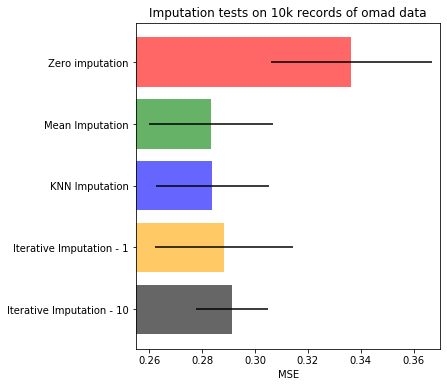

In [30]:
ares = np.array(results)
mses = ares[:, 0] * -1
stds = ares[:, 1]
n_bars = len(ares)
xval = np.arange(n_bars)

x_labels = ['Zero imputation',
            'Mean Imputation',
            'KNN Imputation',
            'Iterative Imputation - 1',
            'Iterative Imputation - 10']
colors = ['r', 'g', 'b', 'orange', 'black']

# plot diabetes results
plt.figure(figsize=(12, 6))
ax1 = plt.subplot(121)
for j in xval:
    ax1.barh(j, mses[j], xerr=stds[j],
             color=colors[j], alpha=0.6, align='center')

ax1.set_title('Imputation tests on 10k records of omad data')
ax1.set_xlim(left=np.min(mses) * 0.9,
             right=np.max(mses) * 1.1)
ax1.set_yticks(xval)
ax1.set_xlabel('MSE')
ax1.invert_yaxis()
ax1.set_yticklabels(x_labels)
